In [18]:
!pip install torch torchvision torchaudio


In [19]:
!pip install numba


In [20]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [21]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


*Importing the data from MNIST Directly*

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST data
mnist = tf.keras.datasets.mnist
# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Convert labels to categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


*Model To be Trained*

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


*Compiling the model*

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


*Training the Model*

In [39]:
trained=model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.9925 - loss: 0.0227 - val_accuracy: 0.9867 - val_loss: 0.0482
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9953 - loss: 0.0141 - val_accuracy: 0.9889 - val_loss: 0.0435
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 73ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.9847 - val_loss: 0.0576
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - accuracy: 0.9960 - loss: 0.0108 - val_accuracy: 0.9868 - val_loss: 0.0468
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 57ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 0.9874 - val_loss: 0.0482


*Visualising Accuracy over epochs*

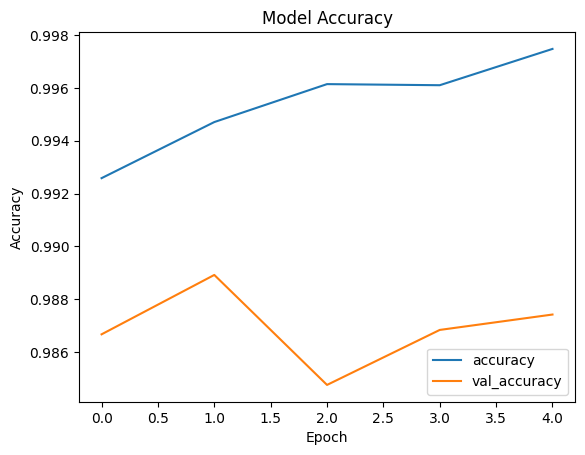

In [42]:
# Plot accuracy over epochs
plt.plot(trained.history['accuracy'], label='accuracy')
plt.plot(trained.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

*Evaluating the Model*

In [16]:

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9871 - loss: 0.0410
Test accuracy: 0.9900000095367432


*Saving The Model*

In [17]:
#Save the model
model.save('mnist_ocr_model.h5')


*FPS Calculate and visualising them*

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Frames Per Second (FPS): 1876.32


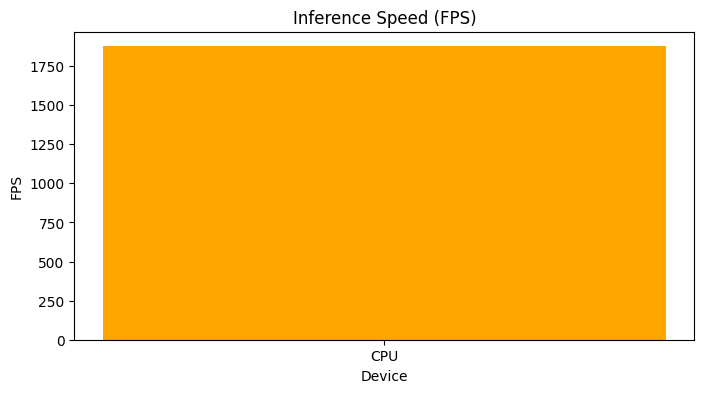

In [43]:
# Function to measure inference time
def measure_inference_time(device, model, test_images, num_images=1000):
    with tf.device(device):
        start_time = time.time()
        model.predict(test_images[:num_images])
        end_time = time.time()
        return num_images / (end_time - start_time)

# Measure FPS on CPU (since GPU is not available)
fps = measure_inference_time('/CPU:0', model, test_images)
print(f"Frames Per Second (FPS): {fps:.2f}")

# Visualize FPS
devices = ['CPU']
fps_values = [fps]

plt.figure(figsize=(8, 4))
plt.bar(devices, fps_values, color=['orange'])
plt.xlabel('Device')
plt.ylabel('FPS')
plt.title('Inference Speed (FPS)')
plt.show()


In [36]:
from tensorflow.keras.models import load_model

model = load_model('mnist_ocr_model.h5')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.evaluate(test_images, test_labels)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9871 - loss: 0.0410


[0.031858477741479874, 0.9900000095367432]

In [25]:
import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the Lite model
with open('mnist_ocr_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp74ksvrq1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134513159091680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159783872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159794256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159798128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159839360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159842880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159843584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134513159847104: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [44]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='mnist_ocr_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on one image from the test dataset
input_shape = input_details[0]['shape']
input_data = np.expand_dims(test_images[0], axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the results
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Predicted digit: {np.argmax(output_data)}")


Predicted digit: 7


*Testing The Trained Model*

In [45]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(_, _), (test_images, test_labels) = mnist.load_data()

# Normalize the images
test_images = test_images / 255.0

# Reshape the images
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Convert labels to categorical
test_labels = to_categorical(test_labels)


In [46]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9886 - loss: 0.0487
Test accuracy: 0.9904999732971191
Test loss: 0.039565373212099075


*Displaying Random OCR Images from test *


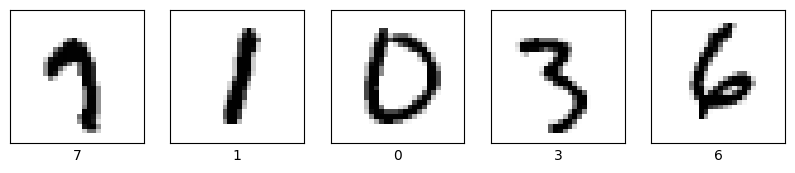

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display random images
def display_random_images(images, labels, num_images=5):
    indices = np.random.choice(range(len(images)), num_images)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[idx].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(np.argmax(labels[idx]))
    plt.show()

# Display random sample images
display_random_images(test_images, test_labels)


*Inference Time Between GPU and CPU of the OCR*

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
GPU inference time for 1000 images: 0.7151 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CPU inference time for 1000 images: 0.3982 seconds


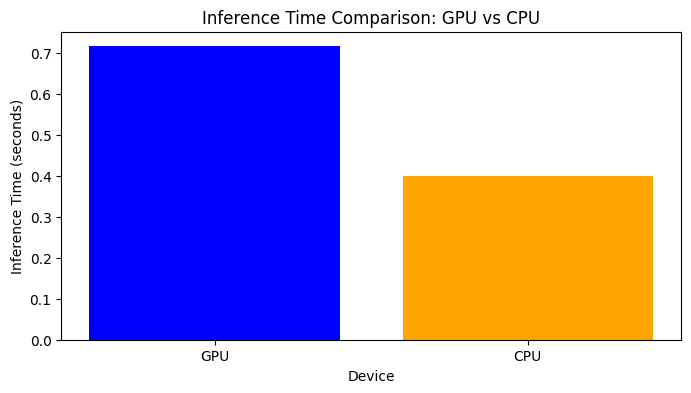

In [48]:
import time

# Measure inference time
def measure_inference_time(device, model, test_images, num_images=1000):
    with tf.device(device):
        start_time = time.time()
        model.predict(test_images[:num_images])
        end_time = time.time()
        return end_time - start_time

# Measure GPU time
gpu_time = measure_inference_time('/GPU:0', model, test_images)
print(f"GPU inference time for 1000 images: {gpu_time:.4f} seconds")

# Measure CPU time
cpu_time = measure_inference_time('/CPU:0', model, test_images)
print(f"CPU inference time for 1000 images: {cpu_time:.4f} seconds")

# Visualize inference times
devices = ['GPU', 'CPU']
times = [gpu_time, cpu_time]

plt.figure(figsize=(8, 4))
plt.bar(devices, times, color=['blue', 'orange'])
plt.xlabel('Device')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: GPU vs CPU')
plt.show()
